In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

## The Fashion-MNIST Dataset

Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement of the original MNIST dataset for benchmarking machine learning algorithms as it is a more challenging dataset. 

For this lab, let's start by loading the Fashion-MNIST dataset using the Torchvision library. When loading, we can transform the images to be flattened vectors of dimension 784 (= 28 x 28).

Once the data has been downloaded, we can plot some of the examples to see what the classes look like.

### Loading the Dataset using PyTorch and the Torchvision Library

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 256

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


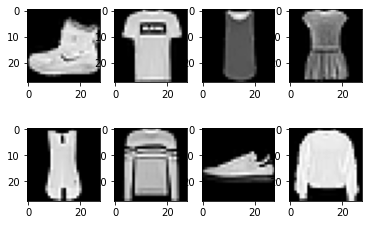

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

for i in range(8):
    plt.subplot(int(str(24)+str(i+1)))
    plt.imshow(train_set.train_data[i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

# Implement an Autoencoder

The next step is to implement a very simple autoencoder algorithm. 

Recall from the lecture, an autoencoder is an unsupervised algorithm that consists of an encoder and a decoder. The input passes through an encoder, which typically contains a bottleneck to reduce to the dimensionality of the input. This latent code, or reduced dimensionality representation of the input is then passed through the decoder to reconstruct the input. The reconstruction will be a lossy version of the input. The encoder and decoder are neural networks and learning is achieved in the same manner as with a neural network.

For this implementation, assume the Encoder (defined below) only has an input and an output. There is no hidden layer in the encoder. Assume the dimensionality of the latent space is $64$.

For the Decoder, again, assume it is a simple dense layer without a hidden layer (simply an input and output layer). For the decoder, the output layer should have a Sigmoid non-linearity as opposed to Relu (which may be used for the other layers).

Start by defining the Encoder and Decoder classes. 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#https://en.wikipedia.org/wiki/Autoencoder#Basic_Architecture

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        

    def forward(self, x):
        # YOUR CODE HERE
        # raise NotImplementedError()
        out = self.lin1(x)
        out = F.relu(out)
        return out

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.lin1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # YOUR CODE HERE
        # raise NotImplementedError()
        out = self.lin1(x)
        out = nn.Sigmoid()(out)
        return out
        

Next, let's test the autoencoder implementation to make sure it is functioning and see what the reconstructed images look like.

The code to test your autoencoder is written below. You will simply need to write the code to display your reconstructed images. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


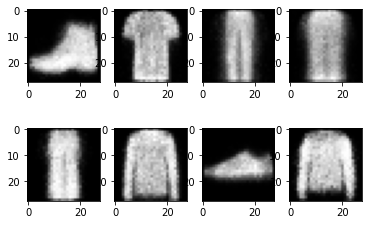

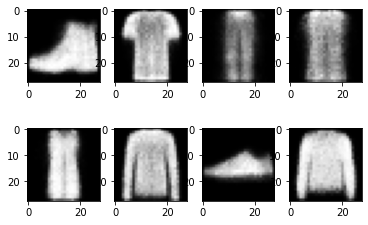

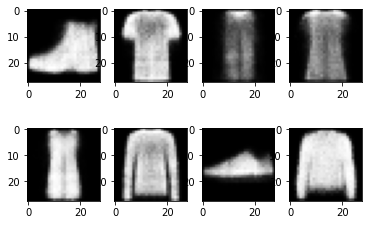

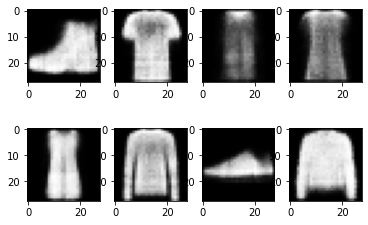

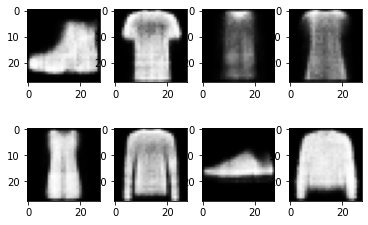

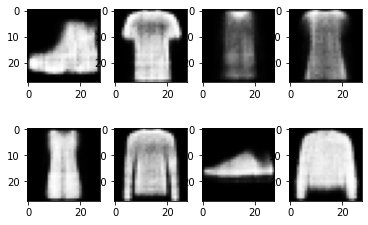

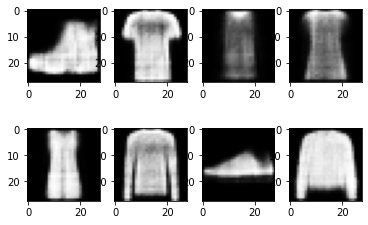

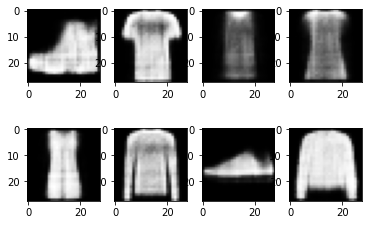

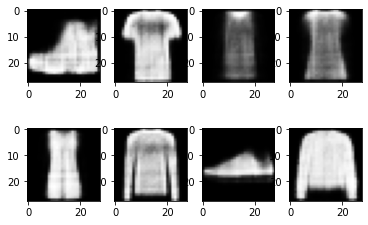

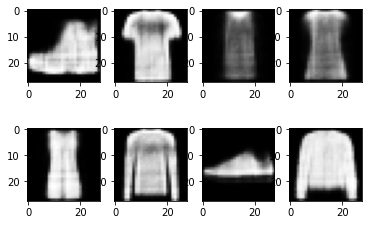

In [25]:
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

# from tqdm import tqdm #tqdm seems problematic
from tqdm import tqdm_notebook as tqdm
from itertools import chain

enc_dim = 64
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    
    ## Display some of the reconstructed images
    # YOUR CODE HERE
    # raise NotImplementedError()
    enc.eval()
    dec.eval()

    for i in range(8):
      input_ims = train_loader.dataset[i][0]
      inputs = enc(input_ims)
      outputs = dec(inputs)
      plt.subplot(int(str(24)+str(i+1)))
      plt.imshow(outputs.detach().numpy().reshape((28,28)),cmap = plt.get_cmap('gray'))
      
    plt.show()
